# 分类器

在用AutoEncoder预训练之后，Encoder已经可以对图像进行编码。这个时候是否可以回归到分类有监督学习？  
有没有方法减少标注数量，做渐进式学习？  

考虑如下分类：  
1. 杂质  
2. 血细胞  
3. 染色体  

这些分类是互斥的，使用Softmax激活。  
对于混合样本，直接丢弃。  
这里要利用Encoder+特征工程对少例分类（血细胞和杂质）进行挖掘，尽量使得分类标注比较均匀。  


### 思路一
首先考虑锁定Encoder参数，只训练分类器，同时先标注简单样本，用BinaryCrossEntropy Loss函数，从而建立起最初的特征-分类映射，作为训练的Baseline。  

此时网络在2个方面有所欠缺：  
1. 对于难样本缺乏区分能力  
2. Embedding本身的分布可能不够理想  

进一步考虑利用Baseline模型，选取难样本进行标注。同时放开Encoder参数，利用Center或Margin Loss函数，训练的目标是改善Embedding分布，提升难样本的区分能力。  
由于这个任务中，有些小染色体与杂质是比较像的，标注可能噪声较高，就不使用Focal Loss对难例进行加强训练。  

如果顺利的话，此时应该就获得了比较理想的分类模型。  
有没有办法进一步对Embedding进行监督，提高Embedding的分布质量？  
有没有办法实现增强学习？  

### 思路二

考虑直接在Embedding上进行训练，即利用Triplet Margin Loss直接计算样本对的距离。  
由于是多分类，3种分类就有9种样本对组合，需要尽量平均生成。  
这样可以改善Embedding的分布。  

猜测此时Embedding会呈现聚类效应，难例分布在概率密度较小的区域。  
由于没有加入FC等回归器，需要在Embedding训练完成后，训练GMM等聚类模型，用于分类预测。  


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
import pickle
import argparse
import itertools
from datetime import datetime
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from tensorboardX import SummaryWriter
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from datasets.simple import *
from resnet import *
from transforms import *
from plot import *
from autoencoder import *

In [2]:
batch_size = 32
device = torch.device('cuda:0')
img_size = 256
target_size = 256

data_root = '/mnt/nvme/data/chromosome'

anno_paths = [
    'neg-chunk.csv'
]

img_path = 'neg-chunk'

In [3]:
# triplet chunk dataset

# paths are absolute!
# support multiple anno paths (in csv), their lines are combined into one large anno dataframe
# csv format: path, classNo

class TripletChunkDataset(Dataset):
    def __init__(
        self,
        data_root,
        img_path,
        anno_paths,
        transform=None
    ):
        self.data_root = data_root
        self.img_path = img_path
        self.anno_paths = anno_paths
        self.transform = transform
        
        self.img_root = os.path.join(self.data_root, self.img_path)
        
        self.anno_df = []
        
        for anno_path in self.anno_paths:
            anno_df = pd.read_csv(os.path.join(self.data_root, anno_path))
            self.anno_df.append(anno_df)
        
        self.anno_df = pd.concat(self.anno_df, axis=0)
        print(self.anno_df.head())
        self.total_len = len(self.anno_df)
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, index):
        # create triplet 
        anchor = self.anno_df.iloc[index]
        anchor_class = self.anno_df.iloc[index, 1]

        positive = self.anno_df[self.anno_df['class']==anchor_class].sample(n=1).iloc[0]
        negative = self.anno_df[self.anno_df['class']!=anchor_class].sample(n=1).iloc[0]
        
        row_triplet = [anchor, positive, negative]
        triplet = []
        
        for row in row_triplet:
            row_path = row['filename']
            file_path = os.path.join(self.img_root, row_path)
            
            row_img = Image.open(file_path)
            
            if self.transform is not None:
                row_img = self.transform(row_img)
                
            triplet.append(row_img)
        
        return tuple(triplet)

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    PadOrCrop(img_size),
    transforms.RandomAffine(30, translate=(0.2, 0.2), resample=PIL.Image.BILINEAR, fillcolor=255),
    transforms.ToTensor(),
    ChannelExpand()
])

triplet_dataset = TripletChunkDataset(
    data_root,
    img_path,
    anno_paths=anno_paths,
    transform=transform
)

triplet_loader = DataLoader(
    triplet_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

                    filename     class
0  L1903012841.010.A_100.jpg  impurity
1    L1903012841.060.A_2.jpg  impurity
2   L1903012841.060.A_31.jpg  impurity
3   L1903012841.060.A_58.jpg  impurity
4    L1903012841.063.A_0.jpg  impurity


In [5]:
# create a embedding resnet

class EmbeddingNet(nn.Module):
    def __init__(self, resnet):
        super(EmbeddingNet, self).__init__()
        self.resnet = resnet

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        
        return x

resnet = models.resnet34(pretrained=True)
model = EmbeddingNet(resnet)

model = model.to(device)

In [6]:
learning_rate = 1e-3
weight_decay = 1e-5

criterion = nn.TripletMarginLoss(margin=5.)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [7]:
train_id = 1
epoches = 200

In [ ]:
# train

iter_count = len(triplet_loader)

writer = SummaryWriter()

for epoch in range(epoches):
    print('epoch: {}/{}'.format(epoch+1, epoches))
    
    with tqdm(total=iter_count, file=sys.stdout) as pbar:
        for iter_no, triplet in enumerate(triplet_loader):
            anchors, positives, negatives = triplet
            
            anchors = anchors.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)
            
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            
            loss = criterion(
                anchor_embeddings,
                positive_embeddings,
                negative_embeddings
            )
            
            loss.backward()
            optimizer.step()

            writer.add_scalar(
                'train/loss',
                loss.item(),
                epoch*iter_count+iter_no
            )
            
            pbar.update(1)
        
        if not os.path.exists('./models'):
            os.mkdir('./models')
            
        torch.save(model.state_dict(), './models/EmbeddingNet-{}-{}.pth'.format(train_id, epoch))

epoch: 1/200
100%|██████████| 66/66 [00:26<00:00,  2.52it/s]
epoch: 2/200
100%|██████████| 66/66 [00:26<00:00,  2.52it/s]
epoch: 3/200
100%|██████████| 66/66 [00:26<00:00,  2.51it/s]
epoch: 4/200
 11%|█         | 7/66 [00:03<00:26,  2.23it/s]

## 分布可视化

1. 现在顺次加载每个Epoch的训练模型，计算样本的分布。  

In [14]:
# simple dataset

class ChunkDataset(Dataset):
    def __init__(
        self,
        data_root,
        anno_paths,
        transform=None
    ):
        self.data_root = data_root
        self.anno_paths = anno_paths
        self.transform = transform
        
        self.anno_df = []
        
        for anno_path in self.anno_paths:
            anno_df = pd.read_csv(anno_path)
            self.anno_df.append(anno_df)
        
        self.anno_df = pd.concat(self.anno_df, axis=0)
        print(self.anno_df.head())
        
        self.total_len = len(self.anno_df)

        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, index):
        row = self.anno_df.iloc[index]
        img_path = os.path.join(self.data_root, os.path.split(row['path'])[1])
        
        img = Image.open(img_path)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img

chunk_dataset = ChunkDataset(data_root, anno_paths, transform=transform)

loader = DataLoader(
    chunk_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8
)

                                                path  classNo
0  /media/ssd-ext4/neg-chunk/L1903042920.046.A_8.jpg        0
1  /media/ssd-ext4/neg-chunk/L1903083406.078.A_11...        0
2  /media/ssd-ext4/neg-chunk/L1903113536.040.A_16...        0
3  /media/ssd-ext4/neg-chunk/L1903123563.277.A_35...        0
4  /media/ssd-ext4/neg-chunk/L1903123702.038.A_17...        0


In [15]:
def draw_2d(embed):
    x, y = embed.transpose()

    fig=plt.figure(figsize=(16,12))
    plt.scatter(x, y)
    plt.show()

In [16]:
cluster_num = 5
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])

def draw_clusters(clusters, cluster_num, embeddings, colors):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1, 1, 1)

    for g, c in zip(range(cluster_num), colors):
        condlist = clusters == g
        cluster = np.compress(condlist, embeddings, axis=0)

        x, y = cluster.transpose()

        ax.scatter(x, y, c=c)

    plt.show()

In [17]:
PIC_SIZE = 6400

def draw_pics(embeddings, filenames):
    fig = plt.figure(figsize=(32,32))
    ax = fig.add_subplot(1, 1, 1)
    
    img = np.full((PIC_SIZE, PIC_SIZE, 3), 255)
    
    rois = []
    
    xs, ys = embeddings.transpose()
    x_max = np.max(xs)
    x_min = np.min(xs)
    y_max = np.max(ys)
    y_min = np.min(ys)
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    for embedding, filename in zip(embeddings, filenames):
        roi_img = cv2.imread(filename)
        w, h, _ = roi_img.shape
        
        x = int(((embedding[0] - x_min) / x_range) * PIC_SIZE)
        y = int(((embedding[1] - y_min) / y_range) * PIC_SIZE)
        
        if (x+w <= PIC_SIZE) and (y+h <= PIC_SIZE):
            img[x:x+w, y:y+h, ...] = roi_img
            
    ax.imshow(img)
    plt.show()
    cv2.imwrite('pic.jpg', img)

epoch: 0/10
100%|██████████| 260/260 [00:30<00:00, 21.90it/s]

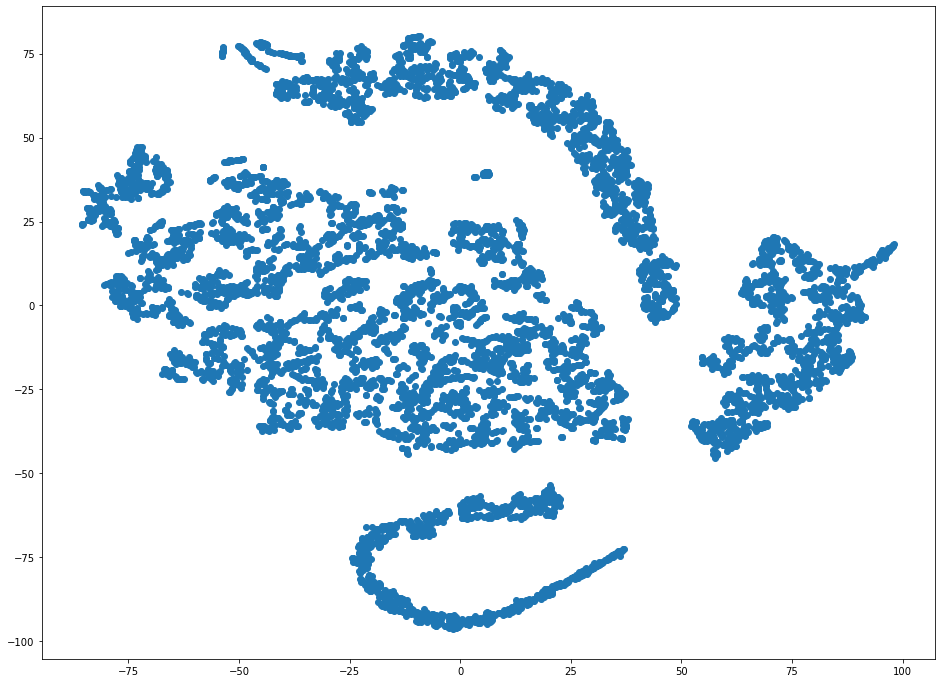

100%|██████████| 260/260 [00:35<00:00,  7.42it/s]
epoch: 1/10
100%|██████████| 260/260 [00:30<00:00, 21.83it/s]

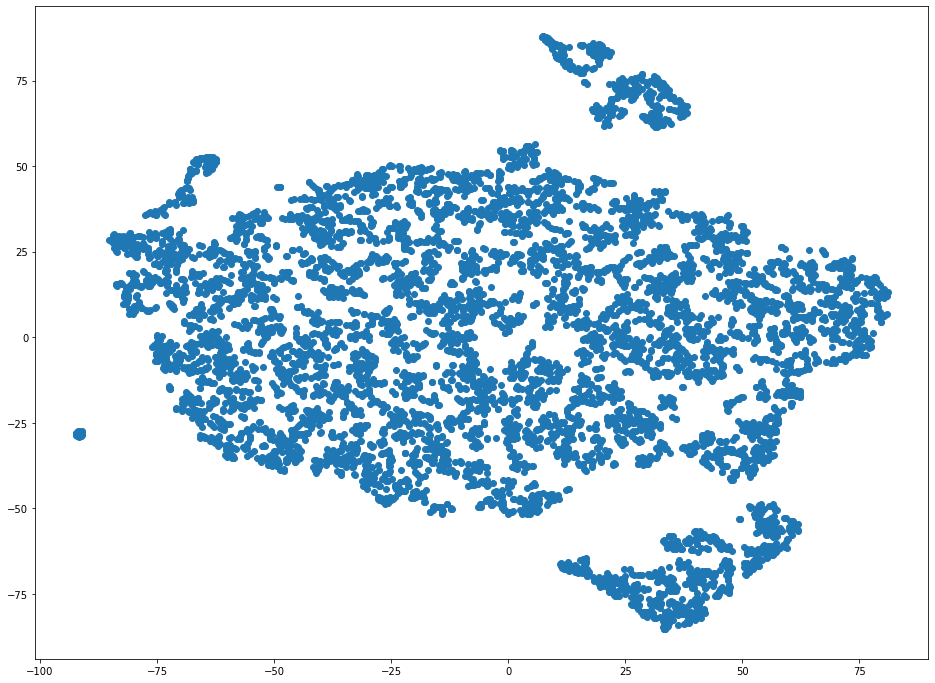

100%|██████████| 260/260 [00:47<00:00,  5.45it/s]
epoch: 2/10
100%|██████████| 260/260 [00:29<00:00, 22.52it/s]

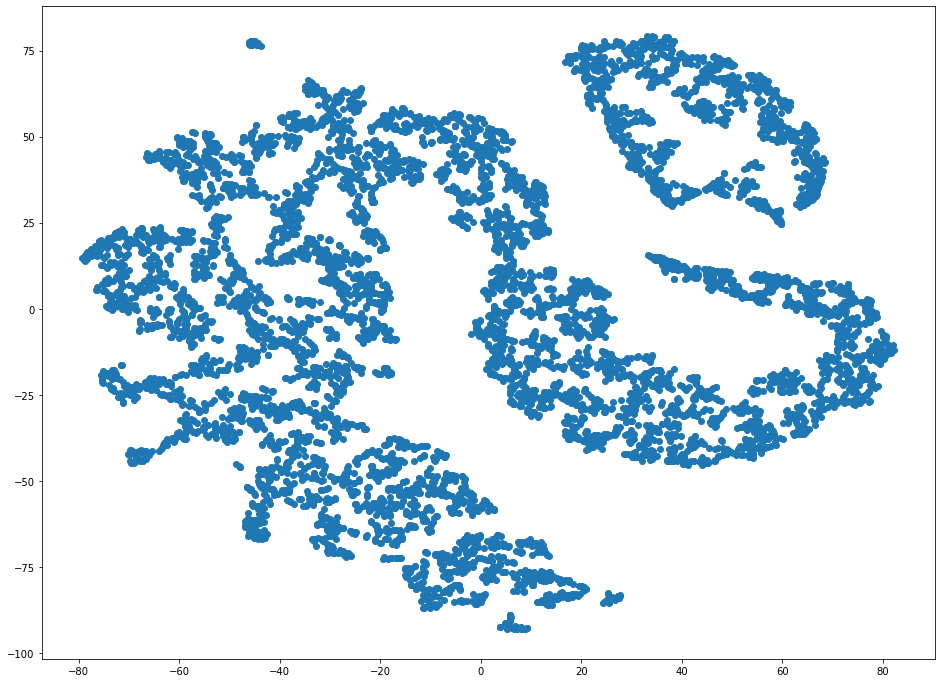

100%|██████████| 260/260 [00:35<00:00,  7.26it/s]
epoch: 3/10
100%|██████████| 260/260 [00:29<00:00, 22.55it/s]

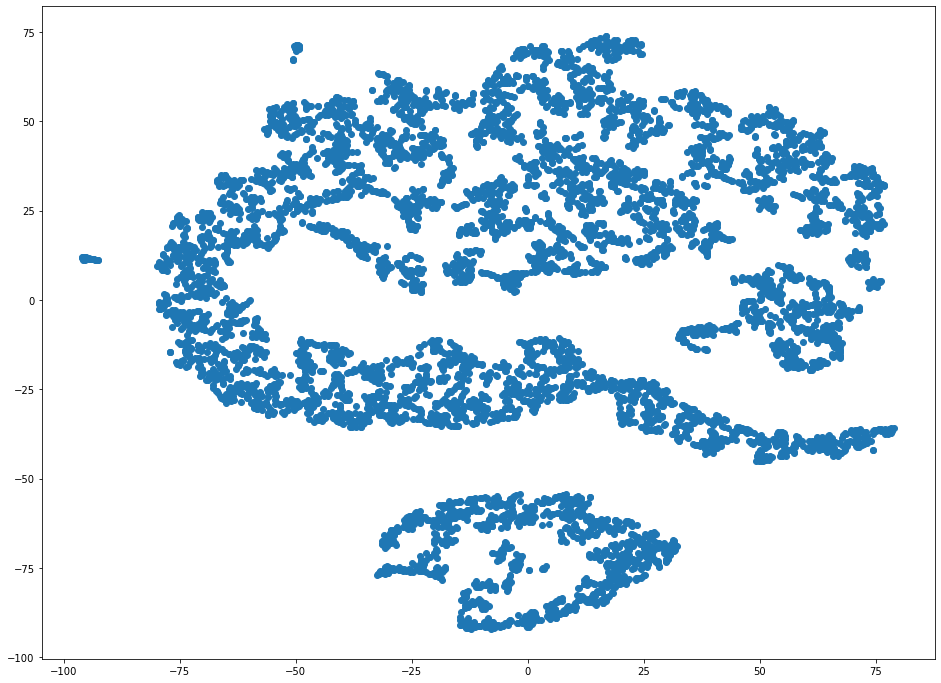

100%|██████████| 260/260 [00:36<00:00,  7.20it/s]
epoch: 4/10
100%|██████████| 260/260 [00:30<00:00, 21.65it/s]

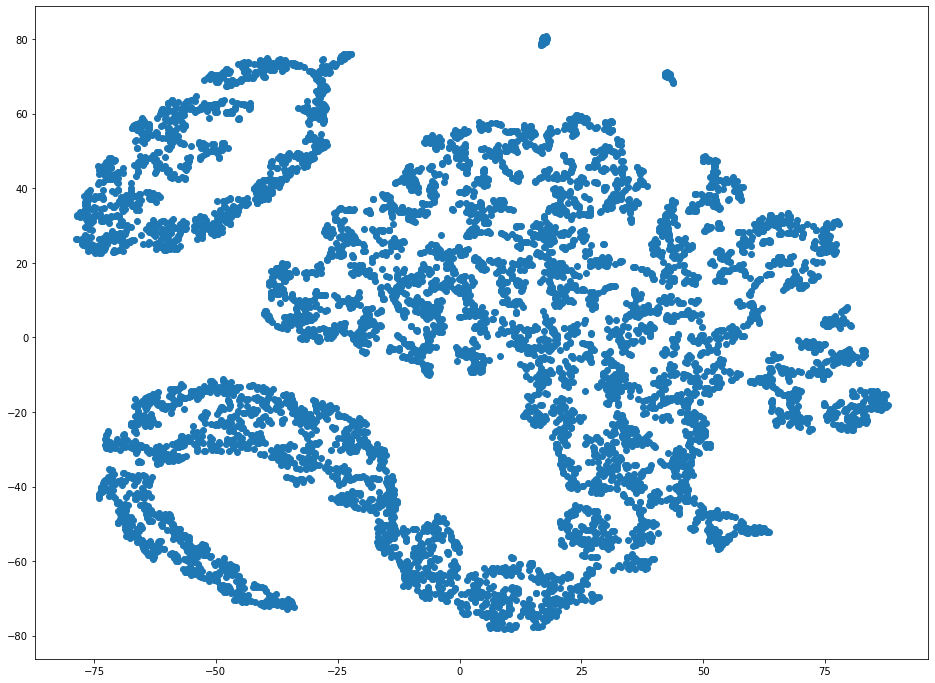

100%|██████████| 260/260 [00:36<00:00,  7.19it/s]
epoch: 5/10


In [ ]:
for epoch in range(epoches):
    print('epoch: {}/{}'.format(epoch, epoches))
    
    model.load_state_dict(torch.load('./models/EmbeddingNet-{}-{}.pth'.format(train_id, epoch)))
    
    with torch.no_grad():
        # get epoch logits
        epoch_logits = []
        
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            for imgs in loader:
                imgs = imgs.cuda()

                logits = model(imgs)
                logits = logits.detach().cpu()

                epoch_logits.append(logits)

                pbar.update(1)

            epoch_logits = torch.cat(epoch_logits)

            # pca
            #pca = PCA(n_components=2)
            #pca_logits = pca.fit_transform(epoch_logits)
            
            # tsne
            tsne_logits = TSNE(n_components=2).fit_transform(epoch_logits)

            # draw
            draw_2d(tsne_logits)
        